# FIN 514 - Project 2 Choice #1 Python Codes_ED
**Spring 2022**

This notebook provides the valuation of Auto Callable Yield Notes Linked to the S&P500® Index due July 21, 2023
Fully and Unconditionally Guaranteed by JPMorgan Chase & Co.

Team members: Ya-Yen,Li(yayenli2) / Wei Ting,Chao(wtchao3) / Yu-Shiuan,Chang(yschang4)

### Part a) Estimated value from Explicit Difference Methods

### Part b) Volatility Sensitive Analysis

### Part c) Non-linearity Analysis

### Part d) Stability Analysis

This notebook provides a simple Explicit Finite Difference Code to value European style options


## Packages and Configurations

The following common packages will be use on this notebook.
* numpy - [https://numpy.org/](https://numpy.org/)
* Pandas - [https://pandas.pydata.org/](https://pandas.pydata.org/)
* matplotlib - [https://matplotlib.org/](https://matplotlib.org/)
* Scipy Statistical functions - [https://docs.scipy.org/doc/scipy/reference/stats.html](https://docs.scipy.org/doc/scipy/reference/stats.html)

In [1]:
import numpy as np
import pandas as pd
import scipy.stats as st
import matplotlib.pyplot as plt

# Part a) Estimated value from Explicit Difference Methods

## Step 1: Set the parameters

In [2]:
jmax = 250        # Number of S steps
imax = 10000      # Number of t steps
S0 = 4577.1       # Original Stock Price (1/18/2022)
sigma = 0.21589   # Annualized (Future) Volatility of Stock Price Returns
r = 0.007555      # Annualized Continously Compounded Risk-free Rate
q = 0.01455       # Continuous Dividend Yield
TM = 549/365      # Time of Maturity Date (T19) (7/21/2023) 
TFR = 546/365     # Time of Final Review Date (T18) (7/18/2023)
SL = 0            # Minimum S value
SU = 2.5*S0       # Maximum S value
CPN = 5.375       # Coupon Payements per month
Trigger = 0.7*S0  # Trigger Barrier

In [3]:
# Review dates for autocall (Final Review Date TFM included)
Review_dates = [90/365, 120/365, 154/365, 181/365, 212/365, 244/365, 273/365, 304/365,
                335/365, 365/365, 399/365, 426/365, 455/365, 485/365, 518/365, 546/365]  

# Payment dates for coupons from T3-T17 (Final Review Date TM NOT included) 
Payment_dates = [93/365, 125/365, 157/365, 184/365, 217/365, 247/365, 276/365, 309/365, 
                 338/365, 370/365,402/365, 429/365, 458/365, 490/365, 521/365]  

# Payment dates for coupons from T1,T2 (no autocall)
CPN_payment_dates = [37/365, 64/365]

In [4]:
# Check for dates

# delta t
dt = TFR / imax 
print(f"dt: {dt}")

# Review dates for autocall (Final Review Date TFR included)
ireview1 = [i/dt for i in Review_dates]      
ireview = [int(i) for i in ireview1]     
print(f"ireview:   {ireview}")

# Payment dates for coupons from T3~T17 (Maturity Date TM NOT included) 
ipayment1 = [i/dt for i in Payment_dates]  
ipayment = [int(i) for i in ipayment1]
print(f"ipayment1: {ipayment}")

# Payment dates for coupons from T1,T2 (coupon only date)
icpn1 = [i/dt for i in CPN_payment_dates]      
icpn = [int(i) for i in icpn1]     
print(f"icpn1:     {icpn}")

# Payment dates for all coupons from T1~T17 
itotal = icpn + ipayment
print(f"itotal:    {itotal}")

dt: 0.0001495890410958904
ireview:   [1648, 2197, 2820, 3315, 3882, 4468, 5000, 5567, 6135, 6684, 7307, 7802, 8333, 8882, 9487, 10000]
ipayment1: [1703, 2289, 2875, 3369, 3974, 4523, 5054, 5659, 6190, 6776, 7362, 7857, 8388, 8974, 9542]
icpn1:     [677, 1172]
itotal:    [677, 1172, 1703, 2289, 2875, 3369, 3974, 4523, 5054, 5659, 6190, 6776, 7362, 7857, 8388, 8974, 9542]


## Step 2: Build the Explicit Difference method function

In [5]:
def EXPFD(S0, Trigger, TM, TFR, r, q, sigma, SU, imax, jmax, CPN, Review_dates, Payment_dates, CPN_payment_dates):
    
    # CREATE TWO DIMENSIONAL ARRAY OF SIZE [imax+1,jmax+1] TO STORE V AND VT AT ALL STEPS
    V  = np.zeros([imax+1, jmax+1])
    VT = np.zeros([imax+1, jmax+1])

    # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
    # A[jmax], B[jmax], C[jmax] 
    A = np.zeros([jmax+1])
    B = np.zeros([jmax+1])
    C = np.zeros([jmax+1])
    
    # Set up time and S steps
    dt = TFR / imax
    dS = SU / jmax
    
    # Set up Autocall and Trigger steps 
    j0 = int(S0/dS)        
    jb = int(Trigger/dS)   
    
    # Review dates for autocall (Final Review Date TM included)
    ireview1 = [i/dt for i in Review_dates]      
    ireview = [int(i) for i in ireview1]    

    # Payment dates for coupons from T3~T17 (Final Review Date TM NOT included) 
    ipayment1 = [i/dt for i in Payment_dates]        
    ipayment = [int(i) for i in ipayment1]       
    
    # Payment dates for coupons from T1,T2 (coupon only date)
    icpn1 = [i/dt for i in CPN_payment_dates]       
    icpn = [int(i) for i in icpn1]      
    
    # Payment dates for all coupons from T1~T17 
    itotal = icpn + ipayment
    
    ### Grid for VT (Trigger event DOES happan) ###########################################################
    
    ### At maturity
    # Calculate option value at maturity VT[imax,j]
    # Also calculate the probabilities A, B, C
    i = imax 
            
    for j in range(0, jmax+1):    

        if j >= j0:  
            VT[i, j] = (1000 + CPN) * np.exp(-r *(TM - TFR))  # Autocall                                   
        else:
            VT[i, j] = (1000 * (j*dS/S0) + CPN) * np.exp(-r *(TM - TFR))
                
        A[j] = (0.5 * (sigma ** 2) * (j ** 2) + 0.5 * (r - q) * j) * dt
        B[j] =  1 - r * dt - sigma ** 2 * j ** 2 * dt
        C[j] = (0.5 * (sigma ** 2) * (j ** 2) - 0.5 * (r - q) * j) * dt

    ### Backward in time
    counter1 = 0
    counter2 = 0
    
    for i in range(imax-1, -1, -1):
        
        # Lower boundary condition for VT
        # VT[i,0]=PV(remaining coupons)
        VT[i, 0] = 0
        
        # Check if i meet the review dates (T18 not included)
        if (i+1) in itotal:         
            counter1 += 1
        if counter1 > 0:
            PV_cpn = []             # List to save the coupons 
            for k in range(1, counter1+1):
                PV_cpn.append(CPN * np.exp(-r *(itotal[-k] * dt - i * dt)))  # Append each coupon in the list
            VT[i, 0] = sum(PV_cpn)  # Sum up the coupons 
    
        # Regular finite difference formula
        for j in range(1, jmax, 1):
                       
            VT[i,j] = A[j]*VT[i+1,j+1]+B[j]*VT[i+1,j]+C[j]*VT[i+1,j-1] 
            
            # Payment dates for coupons T1,T2 (coupon only date) 
            if i in icpn:     
                VT[i,j] += CPN
                
            # Payment dates for coupons T3~T17
            if i in ireview:
                if j * dS >= S0:
                    VT[i,j] = (1000 + CPN) * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))
                else:
                    VT[i,j] += CPN * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))
                    # ipayment[ireview.index(i)]: time of coupon date
                    
        # Upper boundary condition for VT
        if (i+1) in ireview:  # If next time step is autocall date???  
            counter2 += 1  
        VT[i,jmax] = (1000 + CPN) * np.exp(-r * (ireview[-counter2] * dt - i * dt))
        # ireview[-counter2]: time of next autocall
        
    ### Grid for V (Trigger event does NOT happan) ###########################################################
    
    ### At maturity
    # Calculate option value at maturity V[imax,j]
    # Probabilities A, B, C are the same from V
    i = imax 
    
    for j in range(0, jmax+1):
        if j >= jb:
            V[i, j] = (1000 + CPN) * np.exp(-r *(TM - TFR))      
        
    counter3 = 0

    ### Backward in time
    for i in range(imax-1, -1, -1):

        # Lower boundary condition for V
        # Get value from VT
        V[i, jb] = VT[i, jb] 

        # Regular finite difference formula
        for j in range(jb+1, jmax, 1):

            V[i,j] = A[j]*V[i+1,j+1]+B[j]*V[i+1,j]+C[j]*V[i+1,j-1]

            # Payment dates for coupons T1,T2 (coupon only date) 
            if i in icpn:
                V[i,j] += CPN

            # Payment dates for coupons T3~T17
            if i in ireview:
                if j * dS >= S0:  # Autocall
                    V[i,j] = (1000 + CPN) * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))
                else:
                    V[i,j] += CPN * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))
                    # ipayment[ireview.index(i)]: time of coupon date
        
        # Upper boundary condition for V
        if (i+1) in ireview:
            counter3 += 1
        V[i,jmax] = (1000 + CPN) * np.exp(-r * (ireview[-counter3] * dt - i * dt))
        # ireview[-counter3]: time of next autocall
   
    # If value lower than LBC, then get value from VT
    V[:, 0:jb] = VT[:, 0:jb]
    
    # Final option value V[0, j0]
    return V[0, j0]


In [6]:
expfd = EXPFD(S0, Trigger, TM, TFR, r, q, sigma, SU, imax, jmax, CPN, Review_dates, Payment_dates, CPN_payment_dates)
print(expfd)

991.27041730021


# Part b) Volatility Sensitive Analysis

In [7]:
# Volatities from obersavation dates 
vol = [0.3915633, 0.2627887,  # 2022/05/03
       0.3625552, 0.2603371,  # 2022/11/01
       0.3508948, 0.2762897,  # 2022/08/02
       0.3383119, 0.2713139]  # 2023/01/31

In [8]:
# List to save the value 
value_result = []

# Value with different volatilities
for i in vol:
    
    # Make sure the grid is stable
    if imax < TFR * i**2 * jmax**2:
        imax_new = int(TFR * i**2 * jmax**2) + 1000
    else:
        imax_new = imax
        
    note_value = EXPFD(S0, Trigger, TM, TFR, r, q, i, SU, imax_new, jmax, CPN, Review_dates, Payment_dates, CPN_payment_dates)
    output = {'Volatility': i, 'Value': note_value}
    value_result.append(output)

In [9]:
# Print value with different volatilities
value_result

[{'Volatility': 0.3915633, 'Value': 938.8873752087648},
 {'Volatility': 0.2627887, 'Value': 974.208708430126},
 {'Volatility': 0.3625552, 'Value': 946.0829819066246},
 {'Volatility': 0.2603371, 'Value': 975.0204242021177},
 {'Volatility': 0.3508948, 'Value': 949.0435430638315},
 {'Volatility': 0.2762897, 'Value': 969.8787194524749},
 {'Volatility': 0.3383119, 'Value': 952.301722407649},
 {'Volatility': 0.2713139, 'Value': 971.4478363372443}]

# Part c) Non-linearity Analysis

In [13]:
def EXPFD_1(S0, Trigger, TM, TFR, r, q, sigma, SU, imax, jmaxmin, jmaxmax, jmaxstep, CPN, Review_dates, Payment_dates, CPN_payment_dates):
    
    # LIST TO SAVE RESULTS
    expfd_result = []
    
    # Test different jmax
    for jmax in range(jmaxmin, jmaxmax, jmaxstep): 
        
        # Make sure the grid is stable
        if imax < TFR * sigma**2 * jmax**2:
            imax_new = int(TFR * sigma**2 * jmax**2) + 1000
        else:
            imax_new = imax
        
        # CREATE TWO DIMENSIONAL ARRAY OF SIZE [imax+1,jmax+1] TO STORE V AND VT AT ALL STEPS
        V  = np.zeros([imax_new+1, jmax+1])
        VT = np.zeros([imax_new+1, jmax+1])

        # CREATE ONE DIMENSIONAL ARRAY OF SIZE [jmax+1] TO STORE A, B, C VALUES AT ALL STEPS
        # A[jmax], B[jmax], C[jmax] 
        A = np.zeros([jmax+1])
        B = np.zeros([jmax+1])
        C = np.zeros([jmax+1])

        # Set up time and S steps
        dt = TFR / imax_new
        dS = SU / jmax

        # Set up Autocall and Trigger steps 
        j0 = int(S0/dS)        
        jb = int(Trigger/dS)   

        # Review dates for autocall (Final Review Date TM included)
        ireview1 = [i/dt for i in Review_dates]      
        ireview = [int(round(i)) for i in ireview1]    

        # Payment dates for coupons from T3~T17 (Final Review Date TM NOT included) 
        ipayment1 = [i/dt for i in Payment_dates]        
        ipayment = [int(round(i)) for i in ipayment1]       

        # Payment dates for coupons from T1,T2 (coupon only date)
        icpn1 = [i/dt for i in CPN_payment_dates]       
        icpn = [int(round(i)) for i in icpn1]      

        # Payment dates for all coupons from T1~T17 
        itotal = icpn + ipayment

        ### Grid for VT (Trigger event DOES happan) ###########################################################

        ### At maturity
        # Calculate option value at maturity VT[imax,j]
        # Also calculate the probabilities A, B, C
        i = imax_new 

        for j in range(0, jmax+1):    

            if j >= j0:  
                VT[i, j] = (1000 + CPN) * np.exp(TM - TFR)  # Autocall                                   
            else:
                VT[i, j] = (1000 * (j*dS/S0) + CPN) * np.exp(TM - TFR)

            A[j] = (0.5 * (sigma ** 2) * (j ** 2) + 0.5 * (r - q) * j) * dt
            B[j] =  1 - r * dt - sigma ** 2 * j ** 2 * dt
            C[j] = (0.5 * (sigma ** 2) * (j ** 2) - 0.5 * (r - q) * j) * dt

        ### Backward in time
        counter1 = 0
        counter2 = 0

        for i in range(imax_new-1, -1, -1):

            # Lower boundary condition for VT
            # VT[i,0]=PV(remaining coupons)
            VT[i, 0] = 0

            # Check if i meet the review dates (T18 not included)
            if (i+1) in itotal:         
                counter1 += 1
            if counter1 > 0:
                PV_cpn = []             # List to save the coupons 
                for k in range(1, counter1+1):
                    PV_cpn.append(CPN * np.exp(-r *(itotal[-k] * dt - i * dt)))  # Append each coupon in the list
                VT[i, 0] = sum(PV_cpn)  # Sum up the coupons 

            # Regular finite difference formula
            for j in range(1, jmax, 1):

                VT[i,j] = A[j]*VT[i+1,j+1]+B[j]*VT[i+1,j]+C[j]*VT[i+1,j-1] 

                # Payment dates for coupons T1,T2 (coupon only date) 
                if i in icpn:     
                    VT[i,j] += CPN

                # Payment dates for coupons T3~T17
                if i in ireview:
                    if j * dS >= S0:
                        VT[i,j] = (1000 + CPN) * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))
                    else:
                        VT[i,j] += CPN * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))
                        # ipayment[ireview.index(i)]: time of coupon date

            # Upper boundary condition for VT
            if (i+1) in ireview:  # If next time step is autocall date???  
                counter2 += 1  
            VT[i,jmax] = (1000 + CPN) * np.exp(-r * (ireview[-counter2] * dt - i * dt))
            # ireview[-counter2]: time of next autocall

        ### Grid for V (Trigger event does NOT happan) ###########################################################

        ### At maturity
        # Calculate option value at maturity V[imax,j]
        # Probabilities A, B, C are the same from V
        i = imax_new 

        for j in range(0, jmax+1):
            if j >= jb:
                V[i, j] = (1000 + CPN) * np.exp(TM - TFR)      

        counter3 = 0

        ### Backward in time
        for i in range(imax_new-1, -1, -1):

            # Lower boundary condition for V
            # Get value from VT
            V[i, jb] = VT[i, jb] 

            # Regular finite difference formula
            for j in range(jb+1, jmax, 1):

                V[i,j] = A[j]*V[i+1,j+1]+B[j]*V[i+1,j]+C[j]*V[i+1,j-1]

                # Payment dates for coupons T1,T2 (coupon only date) 
                if i in icpn:
                    V[i,j] += CPN

                # Payment dates for coupons T3~T17
                if i in ireview:
                    if j * dS >= S0:  # Autocall
                        V[i,j] = (1000 + CPN) * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))
                    else:
                        V[i,j] += CPN * np.exp(-r * (ipayment[ireview.index(i)] * dt - i * dt))
                        # ipayment[ireview.index(i)]: time of coupon date

            # Upper boundary condition for V
            if (i+1) in ireview:
                counter3 += 1
            V[i,jmax] = (1000 + CPN) * np.exp(-r * (ireview[-counter3] * dt - i * dt))
            # ireview[-counter3]: time of next autocall

        # If value lower than LBC, then get value from VT
        V[:, 0:jb] = VT[:, 0:jb]
        
        # RELAY OUTPUTS TO DICTIONARY
        jcritreal = S0/dS
        jcrit = int(jcritreal)
        jcritB = int(Trigger/dS)+1
        Vcrit = V[0,jcrit]+ (S0 - jcrit * dS) / (dS) * (V[0,jcrit+1] - V[0,jcrit])
        Blambda = round((jcritB*dS - Trigger)/dS, 2)
        output = {'S_steps': jmax, 't_steps': imax_new, 'EXP': Vcrit, 'Lambda': Blambda}
        expfd_result.append(output)
    
    # return different j results
    return expfd_result


### Varying lambda

In [14]:
start_j = 50  # start j (jmaxmin)
end_j = 500   # end j   (jmaxmax)
j_step = 10   # j steps

In [15]:
expfd_varyLamda = EXPFD_1(S0, Trigger, TM, TFR, r, q, sigma, SU, imax, start_j, end_j, j_step, CPN, Review_dates, Payment_dates, CPN_payment_dates)

In [16]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df_varyLamda = pd.DataFrame.from_dict(expfd_varyLamda)

In [17]:
# EXPORT THE DATA TO A CSV FILE
# df_varyLamda.to_csv("/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project2/expfd.csv", index=False)

In [18]:
df_varyLamda.head()

,S_steps,t_steps,EXP,Lambda
0,50,10000,992.665266,1.0
1,60,10000,999.289867,0.2
2,70,10000,997.006957,0.4
3,80,10000,995.309080,0.6
4,90,10000,994.007286,0.8


In [19]:
df_varyLamda.tail()

,S_steps,t_steps,EXP,Lambda
40,450,15118,992.648988,1.0
41,460,15753,993.481606,0.2
42,470,16401,993.171211,0.4
43,480,17063,993.041247,0.6
44,490,17740,992.837233,0.8


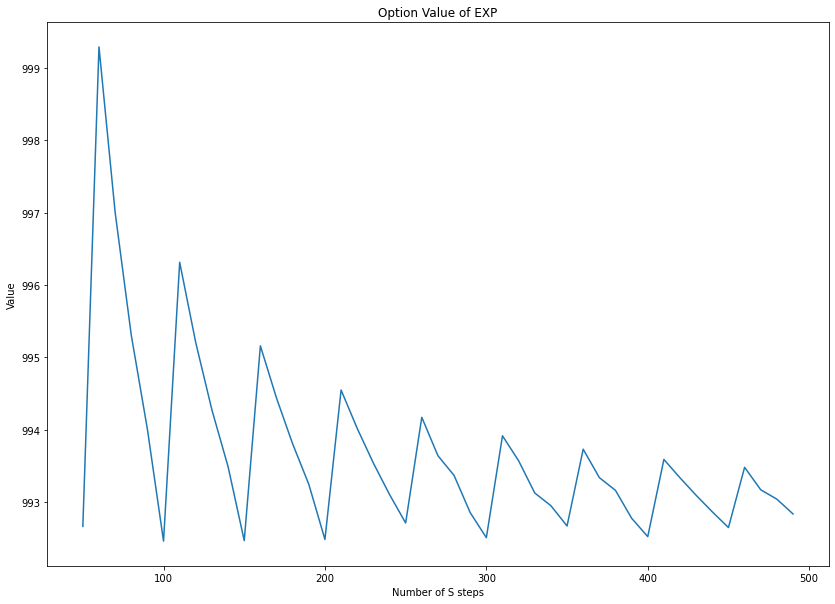

In [20]:
plt.figure(figsize=(14,10))
plt.plot(df_varyLamda['S_steps'], df_varyLamda['EXP'], '-', markersize=3)
plt.title("Option Value of EXP")
plt.xlabel("Number of S steps")
plt.ylabel("Value")
# plt.savefig('/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project2/exp_value.png')
plt.show()

### Lambda=1
In this case, since the continuous barrier (autocall) have the largest error, we can make the grid exactly on the notes,
by selecting lamda=1.

In [21]:
start_j = 50  # start j (jmaxmin)
end_j = 500   # end j   (jmaxmax)
j_step = 25   # j steps

In [22]:
expfd_Lamda1 = EXPFD_1(S0, Trigger, TM, TFR, r, q, sigma, SU, imax, start_j, end_j, j_step, CPN, Review_dates, Payment_dates, CPN_payment_dates)

In [23]:
# CREATE A DATAFRAME FROM THE BINOMIAL MODEL OUTPUT
df_Lamda1 = pd.DataFrame.from_dict(expfd_Lamda1)

In [24]:
df_Lamda1.head()

,S_steps,t_steps,EXP,Lambda
0,50,10000,992.665266,1.0
1,75,10000,992.491358,1.0
2,100,10000,992.462246,1.0
3,125,10000,992.883218,1.0
4,150,10000,992.468759,1.0


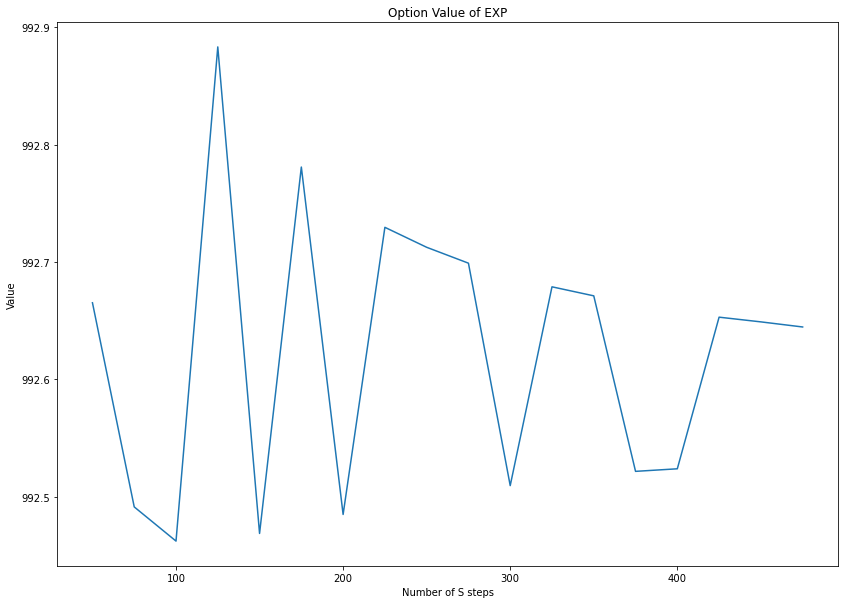

In [25]:
plt.figure(figsize=(14,10))
plt.plot(df_Lamda1['S_steps'], df_Lamda1['EXP'], '-', markersize=3)
plt.title("Option Value of EXP")
plt.xlabel("Number of S steps")
plt.ylabel("Value")
# plt.savefig('/Users/changyushiuan/Desktop/2022Spring/FIN514/Project/Project2/exp_value.png')
plt.show()